#### Import packages and device selection

In [1]:
# TODO: import all sections from main.py
import gc
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 224
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(seed)
torch.manual_seed(seed) # if using CPU
torch.cuda.manual_seed(seed) # if using single-GPU
torch.cuda.manual_seed_all(seed) # if using multi-GPU
torch.backends.cudnn.deterministic = True # deterministic mode
torch.backends.cudnn.benchmark = False # disable auto-tuner to find the best algorithm to use for your hardware
torch.backends.cuda.matmul.allow_tf32 = True # allow TensorFloat-32 on matmul operations
torch.backends.cudnn.allow_tf32  = True # allow TensorFloat-32 on convolution operations

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)

#### This is used only to visualize some samples from the dataset

In [5]:
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] / 255.0 # (H, W, 1) [0..1]
    ab = img[:, :, 1:3] # (H, W, 2) [0..255]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L).astype(np.float32) # (N, H, W, 1)
target_ab = np.array(target_ab).astype(np.uint8) # (N, H, W, 2)

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [6]:
print(input_L.shape, target_ab.shape)

(7129, 224, 224, 1) (7129, 224, 224, 2)


#### Display some samples

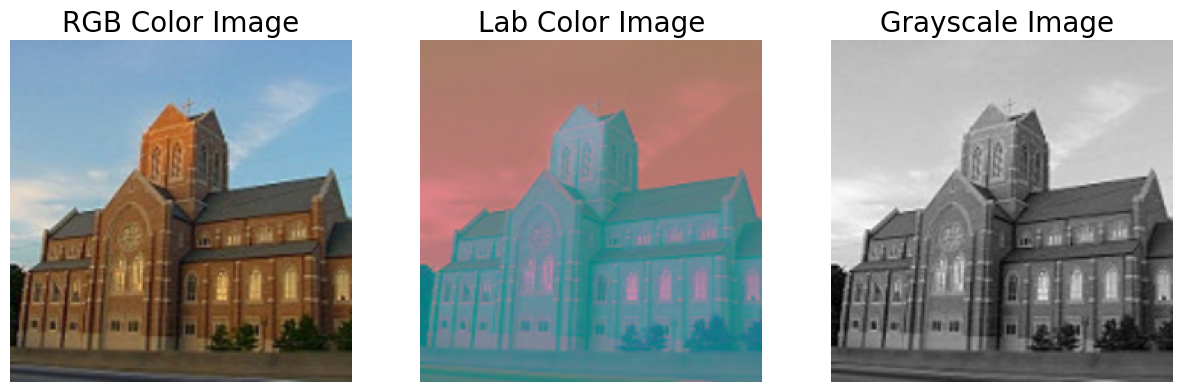

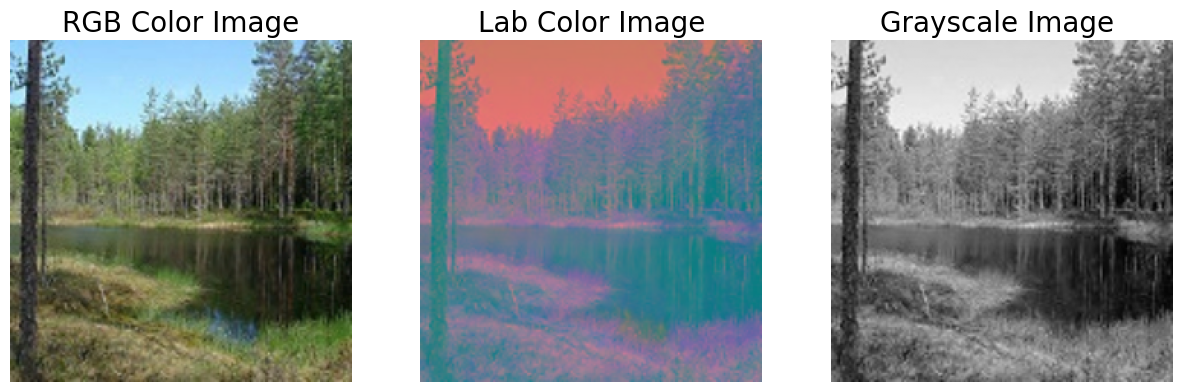

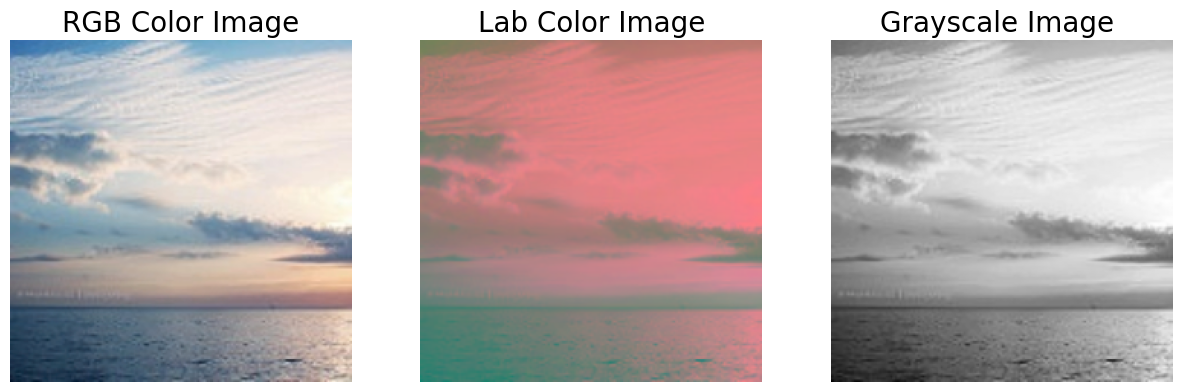

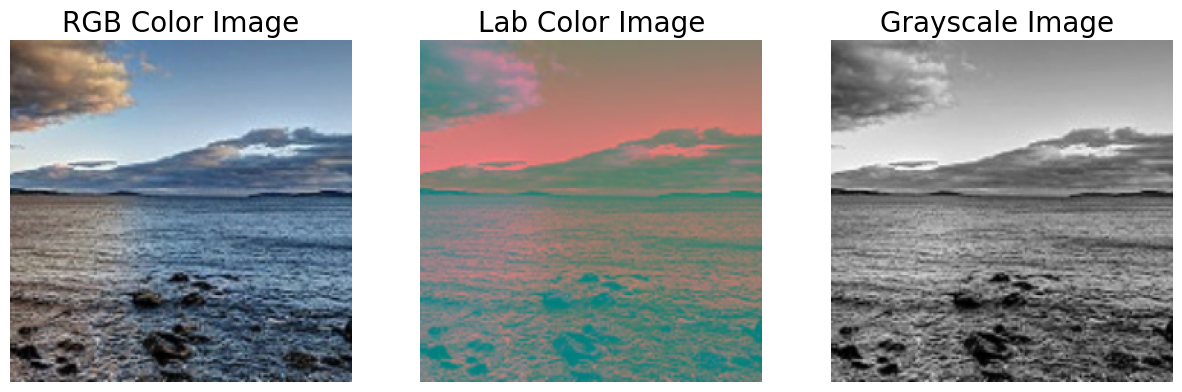

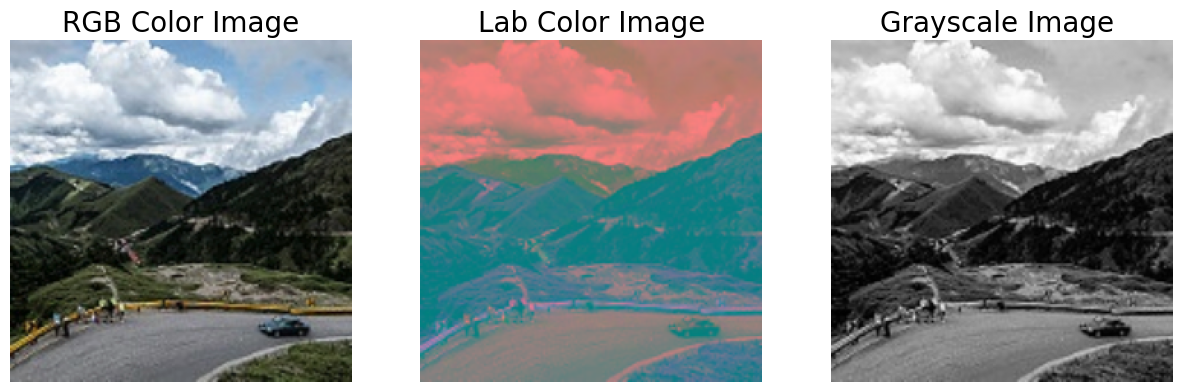

In [7]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] * 255, target_ab[idx]], axis=2).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

In [8]:
del input_L, target_ab
all_filepaths = np.array([os.path.join(path, file) for file in folder])
train_data, test_data = train_test_split(all_filepaths, test_size=0.3, random_state=seed)
val_data, test_data = train_test_split(test_data, test_size=0.3, random_state=seed)

In [9]:
print(train_data.shape, val_data.shape, test_data.shape)

(4990,) (1497,) (642,)


In [10]:
def unstandardize(tensor, mean, std):
    og_shape = tensor.shape
    C, H, W = og_shape[-3:]
    if not torch.is_tensor(mean):
        mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device)
    if not torch.is_tensor(std):
        std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device)

    tensor = (tensor.reshape(-1, C, H, W) * std.reshape(1, C, 1, 1) + mean.reshape(1, C, 1, 1)).clamp(0, 1)  # unnormalize to [0, 1]
    return tensor.reshape(og_shape)  # restore original shape

def compute_ab_prior(dataloader):
    hist = torch.zeros(313)
    total = 0
    for _, labels in dataloader:
        hist += torch.bincount(labels.reshape(-1), minlength=313)  # accumulate histogram
        total += labels.numel()
        del labels
    return hist / total # p(c)

def make_rebalancing_weights(priors, alpha=0.5):
    C = priors.size(0)
    uniform = torch.full_like(priors, 1.0 / C, device=device)
    smoothed = (1.0 - alpha) * uniform + alpha * priors
    weights = 1.0 / smoothed # inverse of smoothed priors (Cross entropies) [0..inf]
    return weights / weights.mean()

def lab_to_rgb(x):
    lab = x.permute(1, 2, 0)
    L = (lab[:, :, 0] * 255).cpu().numpy().astype(np.uint8)
    a = (lab[:, :, 1] * 255).cpu().numpy().astype(np.uint8)
    b = (lab[:, :, 2] * 255).cpu().numpy().astype(np.uint8)
    lab_cv = np.stack([L, a, b], axis=2)
    rgb = cv2.cvtColor(lab_cv, cv2.COLOR_LAB2RGB)
    return rgb

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, L_transform=None, ab_transform=None):
        self.filepaths = filepaths
        self.L_transform = L_transform
        self.ab_transform = ab_transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img = cv2.resize(img, (SIZE, SIZE))
        L = (img[:, :, 0:1].astype(np.float32) / 255.0).transpose(2, 0, 1) # (1, H, W) [0..1]
        ab = (img[:, :, 1:3].astype(np.float32) / 255.0).transpose(2, 0, 1) # (2, H, W) [0..1]
        L_data = torch.from_numpy(L)
        ab_data = torch.from_numpy(ab).long()
        if self.L_transform:
            L_data = self.L_transform(L_data)
        if self.ab_transform:
            ab_data = self.ab_transform(ab_data)
        return L_data, ab_data

In [12]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_ab = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_ab = next(self.loader)
        except StopIteration:
            self.next_L = None
            return
        with torch.cuda.stream(self.stream):
            self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
            self.next_ab = self.next_ab.to(device, non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        L, ab = self.next_L, self.next_ab
        self._preload()
        return L, ab

# class CUDAPrefetcher:
#     def __init__(self, loader):
#         self.loader = iter(loader)
#         self.stream = torch.cuda.Stream()
#         self.next_L = None
#         self.next_labels = None
#         self._preload()
#
#     def _preload(self):
#         try:
#             self.next_L, self.next_labels = next(self.loader)
#         except StopIteration:
#             self.next_L = None
#             return
#         with torch.cuda.stream(self.stream):
#             self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
#             self.next_labels = self.next_labels.to(device, non_blocking=True)
#
#     def next(self):
#         torch.cuda.current_stream().wait_stream(self.stream)
#         L, labels = self.next_L, self.next_labels
#         self._preload()
#         return L, labels

In [13]:
cluster_path = '../data/pts_in_hull.npy'
assert os.path.exists(cluster_path), "Download pts_in_hull.npy and place next to this script"
cluster_centers = torch.from_numpy(np.load(cluster_path)).float() # (313, 2) [-128..127]
cc_l2 = (cluster_centers ** 2).sum(dim=1) # (313,)
lut_coords  = (((torch.stack(torch.meshgrid(torch.arange(256), torch.arange(256), indexing='xy'), dim=-1).float()) - 128.0)
               .reshape(-1, 2)) # (65536, 2) [-128..127]

def compute_dist(tensor):
    dists = ((tensor ** 2).sum(dim=1, keepdim=True) # (B*H*W, 1)
             + cc_l2.reshape(1, -1) # (1, 313)
             - 2 * torch.matmul(tensor, cluster_centers.t())) # (B*H*W, 313)
    return dists

dists = compute_dist(lut_coords)
del lut_coords
# lut = torch.argmin(dists, dim=1).long() # (65536,) [0..312] LUT for mapping (a, b) to cluster index
soft_lut_probs = torch.softmax(-dists, dim=1)  # shape: (65536, 313)
lut = torch.argmax(soft_lut_probs, dim=1).long()  # shape: (65536,)
del dists

In [14]:
temp_dataset = MyDataset(train_data, lut)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
L_pixel_count, L_sum, L_sum_sq = 0, 0.0, 0.0
ab_pixel_count, ab_sum, ab_sum_sq = 0, 0.0, 0.0
for l, ab in tqdm(temp_loader, desc='Computing L and ab channel mean and std'):
    l = l.float()
    ab = ab.float()
    L_sum += torch.sum(l)
    L_sum_sq += torch.sum(l ** 2)
    L_pixel_count += l.numel()
    ab_sum += torch.sum(ab)
    ab_sum_sq += torch.sum(ab ** 2)
    ab_pixel_count += ab.numel()
L_mean = (L_sum / L_pixel_count).item()
L_std = torch.sqrt((L_sum_sq / L_pixel_count) - (L_mean ** 2)).item()
ab_mean = (ab_sum / ab_pixel_count).item()
ab_std = torch.sqrt((ab_sum_sq / ab_pixel_count) - (ab_mean ** 2)).item()
del temp_dataset, temp_loader, l, ab, L_sum, L_sum_sq, L_pixel_count, ab_sum, ab_sum_sq, ab_pixel_count

Computing L and ab channel mean and std:   0%|          | 0/78 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_526085/746173697.py", line 19, in __getitem__
    if self.L_transform:
RuntimeError: Boolean value of Tensor with more than one value is ambiguous


In [ ]:
print(L_mean, L_std)
print(ab_mean, ab_std)

In [ ]:
trainset = MyDataset(train_data, L_transform=transforms.Normalize(mean=L_mean, std=L_std), ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
valset = MyDataset(val_data, L_transform=transforms.Normalize(mean=L_mean, std=L_std), ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
testset = MyDataset(test_data, L_transform=transforms.Normalize(mean=L_mean, std=L_std), ab_transform=transforms.Normalize(mean=ab_mean, std=ab_std))
del train_data, val_data, test_data

## Training pipeline

#### Early stopping used to stop training if model begins to overfit

In [ ]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=0.05):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def fit(net, trainloader, optimizer, scaler, loss_fn, beta=0.5):
    net.train()
    loss_sum = torch.zeros(1, device=device) # sum of per-pixel losses
    pixel_acc = torch.zeros(1, device=device) # total correct pixels
    pixel_total = torch.zeros(1, device=device) # total valid pixels
    image_acc = torch.zeros(1, device=device) # sum of per-image accuracies
    image_count = torch.zeros(1, device=device) # count of images contributing to per-image metric
    prefetcher = CUDAPrefetcher(trainloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            loss_clf = loss_fn(out, targets)
            loss_kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1).mean()
            loss = loss_clf + beta * loss_kld
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(net.parameters(), 3)
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            valid = torch.ones_like(targets, dtype=torch.bool)
            # Pixel accuracy
            correct = (out.argmax(1) == targets) & valid
            pixel_acc += correct.sum()
            batch_valid_pixels = valid.sum()
            pixel_total += batch_valid_pixels
            # Mean per-image accuracy
            B = targets.size(0)
            correct_per = correct.reshape(B, -1).sum(dim=1)
            valid_per = valid.reshape(B, -1).sum(dim=1)
            valid_imgs = valid_per > 0
            if valid_imgs.any():
                image_acc += (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
                image_count += valid_imgs.sum()
            # Loss averaging across epoch
            if batch_valid_pixels.item() > 0:
                loss_sum += loss.detach() * batch_valid_pixels
        # Get the next batch from the prefetcher
        inputs, targets = prefetcher.next()
    # Safeguards against division by zero
    total_valid_pixels = pixel_total.clamp_min(1)
    total_valid_images = image_count.clamp_min(1)
    return ((loss_sum / total_valid_pixels).item(), (pixel_acc / total_valid_pixels).item(),
            (image_acc / total_valid_images).item())

@torch.inference_mode()
def predict(net, valloader, loss_fn, beta=0.5):
    net.eval()
    loss_sum = torch.zeros(1, device=device)
    pixel_acc = torch.zeros(1, device=device)
    pixel_total = torch.zeros(1, device=device)
    image_acc = torch.zeros(1, device=device)
    image_count = torch.zeros(1, device=device)
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            loss_clf = loss_fn(out, targets)
            loss_kld = ((-0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())) /
                        (inputs.size(0) * inputs.size(2) * inputs.size(3)))  # normalize by batch*H*W
            loss = loss_clf + beta * loss_kld
        valid = torch.ones_like(targets, dtype=torch.bool)
        # Pixel accuracy
        correct = (out.argmax(1) == targets) & valid
        pixel_acc += correct.sum()
        batch_valid_pixels = valid.sum()
        pixel_total += batch_valid_pixels
        # Mean per-image accuracy
        B = targets.size(0)
        correct_per = correct.reshape(B, -1).sum(dim=1)
        valid_per = valid.reshape(B, -1).sum(dim=1)
        valid_imgs = valid_per > 0
        if valid_imgs.any():
            image_acc += (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
            image_count += valid_imgs.sum()
        # Loss averaging across epoch
        if batch_valid_pixels.item() > 0:
            loss_sum += loss.detach() * batch_valid_pixels
        # Get the next batch from the prefetcher
        inputs, targets = prefetcher.next()
    # Safeguards against division by zero
    total_valid_pixels = pixel_total.clamp_min(1)
    total_valid_images = image_count.clamp_min(1)
    return ((loss_sum / total_valid_pixels).item(), (pixel_acc / total_valid_pixels).item(),
            (image_acc / total_valid_images).item())

#### Objective method for k fold cross validation

In [ ]:
def objective(trial, trainset, scaler, X):
    num_cycles = trial.suggest_int('num_cycles', 4, 10)
    cycle_length = num_epochs // num_cycles
    final_beta = 0.5
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0.0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        prior = compute_ab_prior(trainloader)
        weights = make_rebalancing_weights(prior, alpha=0.5)
        criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').to(device, memory_format=torch.channels_last)
        net = Net().to(device, memory_format=torch.channels_last)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        for epoch in range(50):
            cycle_pos = epoch % cycle_length
            beta = final_beta * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
            train_loss, train_pix_acc, train_img_acc = fit(net, trainloader, optimizer, scaler, criterion, beta)
            val_loss, val_pix_acc, val_img_acc = predict(net, valloader, criterion, beta)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            scheduler.step(val_loss)
            prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, beta={beta:.3f} | "
                                     f"Metrics train/val: Pixel Acc={train_pix_acc:.3f}/{val_pix_acc:.3f}, "
                                     f"Image Acc={train_img_acc:.3f}/{val_img_acc:.3f} | Loss: {train_loss:.3f}/{val_loss:.3f}")
        del net, optimizer, scheduler
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_dim):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()  # Flatten the 3D output into a 1D vector
        )
        self.fc_mu = nn.Linear(256 * 28 * 28, latent_dim)  # 31 is the dimension of the feature map
        self.fc_logvar = nn.Linear(256 * 28 * 28, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256 * 28 * 28)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 28, 28)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoder_input = self.decoder_input(z)
        x = self.decoder(decoder_input)
        return x, mu, logvar

In [ ]:
writer = SummaryWriter('../runs')
net = Net().eval()
torch.quantization.fuse_modules(net, [
    ['conv3', 'bnorm1'],
    ['conv4', 'bnorm2'],
    ['conv5', 'bnorm3']
], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [ ]:
# del dummy
# gc.collect()
# torch.cuda.empty_cache()
# X = np.zeros(len(trainset))
# torch.cuda.empty_cache()
# scaler = torch.cuda.amp.GradScaler()
# study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
# study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

In [ ]:
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
#
# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))
#
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

#### Entire dataset

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.AdamW(net.parameters(), lr=1e-4, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
prior = compute_ab_prior(trainloader).to(device)
weights = make_rebalancing_weights(prior, alpha=0.5)
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').to(device, memory_format=torch.channels_last)
del prior, dummy
gc.collect()
torch.cuda.empty_cache()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

Only for testing botttlenecks

In [ ]:
# import torch.autograd.profiler as prof
#
# scaler = torch.cuda.amp.GradScaler()
# with prof.profile(record_shapes=True, use_cuda=True) as p:
#     with prof.record_function("train_step"):
#         _, *_ = fit(net, trainloader, optimizer, scaler, criterion)
# print(p.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [ ]:
early_stopping = EarlyStopping()
train_losses, train_pix_accs, train_img_accs = [], [], []
val_losses, val_pix_accs, val_img_accs = [], [], []
last_checkpoint = None
num_epochs = 50
num_cycles = 4
cycle_length = num_epochs // num_cycles
final_beta = 0.5
prog_bar = tqdm(range(num_epochs), total=num_epochs, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Val Loss')
ax.legend()

scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    cycle_pos = epoch % cycle_length
    beta = final_beta * (0.5 * (1 + np.cos(np.pi * (1 - cycle_pos / cycle_length))))
    train_loss, train_pix_acc, train_img_acc = fit(net, trainloader, optimizer, scaler, criterion, beta)
    train_losses.append(train_loss)
    train_pix_accs.append(train_pix_acc)
    train_img_accs.append(train_img_acc)
    val_loss, val_pix_acc, val_img_acc = predict(net, valloader, criterion, beta)
    val_losses.append(val_loss)
    val_pix_accs.append(val_pix_acc)
    val_img_accs.append(val_img_acc)
    #scheduler.step(val_img_acc)
    #early_stopping(val_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr={current_lr}, beta={beta:.3f} | "
                             f"Metrics train/val: Pixel Acc={train_pix_acc:.3f}/{val_pix_acc:.3f}, "
                             f"Image Acc={train_img_acc:.3f}/{val_img_acc:.3f} | Loss: {train_loss:.3f}/{val_loss:.3f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    update_plot()
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
save_checkpoint(net, 'lastcheck')
writer.flush()

In [ ]:
%matplotlib inline

class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [ ]:
@torch.inference_mode()
def final_predict(net, valloader, loss_fn, beta=0.5):
    net.eval()
    loss_sum = torch.zeros(1, device=device)
    pixel_acc = torch.zeros(1, device=device)
    pixel_total = torch.zeros(1, device=device)
    image_acc = torch.zeros(1, device=device)
    image_count = torch.zeros(1, device=device)
    ins, preds_soft, preds_hard, truths = [], [], [], []
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    batch_bar = tqdm(total=len(valloader), desc='Final Predicting', leave=False)
    while inputs is not None:
        with torch.cuda.amp.autocast():
            out, mu, logvar = net(inputs)
            loss_clf = loss_fn(out, targets)
            loss_kld = ((-0.5 * torch.mean(1 + logvar - mu ** 2 - logvar.exp())) /
                        (inputs.size(0) * inputs.size(2) * inputs.size(3)))  # normalize by batch*H*W
            loss = loss_clf + beta * loss_kld
        valid = torch.ones_like(targets, dtype=torch.bool)
        # Pixel accuracy
        correct = (out.argmax(1) == targets) & valid
        pixel_acc += correct.sum()
        batch_valid_pixels = valid.sum()
        pixel_total += batch_valid_pixels
        # Mean per-image accuracy
        B = targets.size(0)
        correct_per = correct.reshape(B, -1).sum(dim=1)
        valid_per = valid.reshape(B, -1).sum(dim=1)
        valid_imgs = valid_per > 0
        if valid_imgs.any():
            image_acc += (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
            image_count += valid_imgs.sum()
        # Loss averaging across epoch
        if batch_valid_pixels.item() > 0:
            loss_sum += loss.detach() * batch_valid_pixels
        ins.append(inputs.cpu())
        ab_pred_soft = torch.einsum('bchw,cd->bdhw', torch.softmax(out.float(), dim=1), cluster_centers)
        preds_soft.append(ab_pred_soft.cpu())
        ab_pred_hard = cluster_centers[out.argmax(1)].permute(0, 3, 1, 2)
        preds_hard.append(ab_pred_hard.cpu())
        truths.append((cluster_centers[targets] + 128).permute(0, 3, 1, 2).cpu())
        inputs, targets = prefetcher.next()
        batch_bar.update(1)
    batch_bar.close()
    # Safeguards against division by zero
    total_valid_pixels = pixel_total.clamp_min(1)
    total_valid_images = image_count.clamp_min(1)
    return (ins, preds_soft, preds_hard, truths, (loss_sum / total_valid_pixels).item(),
            (pixel_acc / total_valid_pixels).item(), (image_acc / total_valid_images).item())

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
cluster_centers = cluster_centers.to(device)
net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds_soft, preds_hard, truths, test_loss, test_pix_acc, test_img_acc = final_predict(net, testloader, criterion, beta)
net_script = ModelWithLoss(net, nn.CrossEntropyLoss(weight=weights, reduction='mean'))
net_script = torch.jit.script(net_script)
net_script.save('../models/model_and_loss.pt')

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
ins = unstandardize(torch.cat(ins, dim=0), L_mean, L_std)
preds_soft = torch.cat(preds_soft, dim=0)
preds_hard = torch.cat(preds_hard, dim=0)
truths = torch.cat(truths, dim=0)

preds_rgb_soft = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_soft)]
preds_rgb_hard = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_hard)]
truths_rgb = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, truths)]

In [ ]:
print(test_loss, test_pix_acc, test_img_acc)

In [ ]:
plt.figure()
plt.plot(train_pix_accs, label='Train pixel accuracy')
plt.plot(val_pix_accs, label='Val pixel accuracy')
plt.axhline(y=test_pix_acc, color='g', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_img_accs, label='Train per image accuracy')
plt.plot(val_img_accs, label='Test per image accuracy')
plt.axhline(y=test_img_acc, color='g', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.axhline(y=test_loss, color='g', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.title('Gray', fontsize=20)
    plt.imshow(ins[idx].squeeze().cpu().numpy() , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title('Predicted (Soft)', fontsize=20)
    plt.imshow(preds_rgb_soft[idx])
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Predicted (Hard)', fontsize=20)
    plt.imshow(preds_rgb_hard[idx])
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Groundtruth', fontsize=20)
    plt.imshow(truths_rgb[idx])
    plt.axis('off')
    plt.show()